In [84]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageOps, ImageFilter

import torch
import torchvision

import os
import glob
import time
import random
from tqdm import tqdm_notebook

In [2]:
class VIEW(torch.nn.Module):
    def __init__(self,):
        super(VIEW, self).__init__()
    
    def forward(self, x):
        s = x.shape
        return x.view(-1, s[1]*s[2]*s[3])

In [180]:
class discriminator(torch.nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        
        self.model = torch.nn.Sequential(
                     torch.nn.Conv2d(1, 64, 4, padding=1, stride=2),
                     #torch.nn.BatchNorm2d(64),
                     torch.nn.ReLU(),
                     torch.nn.Conv2d(64, 128, 4, padding=1, stride=2, bias=False),
                     torch.nn.BatchNorm2d(128),
                     torch.nn.ReLU(),
                     torch.nn.Conv2d(128, 256, 4, padding=1, stride=2, bias=False),
                     torch.nn.BatchNorm2d(256),
                     torch.nn.ReLU(),
                     torch.nn.Conv2d(256, 512, 4, padding=1, stride=2, bias=False),
                     torch.nn.BatchNorm2d(512),
                     torch.nn.ReLU(),
                     VIEW(),
                     torch.nn.Linear(8192, 2),
                     #torch.nn.Sigmoid(),
                     #torch.nn.Softmax()
                )
        
    def forward(self, x):
        return self.model(x)

In [181]:
discriminator = discriminator()

In [182]:
discriminator(torch.Tensor(np.zeros((5,1,64,64)))).shape

torch.Size([5, 2])

In [183]:
class reshape(torch.nn.Module):
    def __init__(self, size):
        super(reshape, self).__init__()
        self.size = size
        
    def forward(self, x):
        return x.view(self.size)

In [184]:
class generator(torch.nn.Module):
    def __init__(self, input_size):
        super(generator, self).__init__()
        self.input_size = input_size
        #self.alpha = alpha
        self.model = torch.nn.Sequential(
                     torch.nn.Linear(self.input_size,8192),
                     reshape((-1,512,4,4)),
                     #torch.BatchNorm2d(512),
                     #torch.nn.ReLU(),
                     #torch.nn.Conv2d(512, 512, 4, padding=1, padding_mode = 'zeros'),
                     #torch.nn.ReLU(),
            
                     torch.nn.ConvTranspose2d(512, 256, 4, padding=1, stride=2, bias=False),
                     torch.nn.BatchNorm2d(256),
                     torch.nn.ReLU(),
            
                     torch.nn.ConvTranspose2d(256, 128, 4, padding=1, stride=2, bias=False),
                     torch.nn.BatchNorm2d(128),
                     torch.nn.ReLU(),

                     torch.nn.ConvTranspose2d(128, 64, 4, padding=1, stride=2, bias=False),
                     torch.nn.BatchNorm2d(64),
                     torch.nn.ReLU(),
            
                     torch.nn.Conv2d(64, 64, 3, padding=1, padding_mode = 'zeros', bias = False),
                     torch.nn.BatchNorm2d(64),
                     torch.nn.ReLU(),  
            
                     torch.nn.ConvTranspose2d(64, 1, 4, padding=1, stride=2, bias=False),
                     torch.nn.ReLU(),

                     torch.nn.Conv2d(1, 1, 3, padding=1, padding_mode = 'zeros'),
                     torch.nn.Sigmoid(),
            
                )
        
        
    def forward(self, input):
        return self.model(input)

In [185]:
dimension = 100
generator = generator(dimension)

In [186]:
generator(torch.Tensor(np.ones((5,100)))).shape

torch.Size([5, 1, 64, 64])

In [187]:
image_loader = torchvision.transforms.ToTensor()
image_unloader = torchvision.transforms.ToPILImage()

class dataloader(torch.nn.Module):
    def __init__(self, path):
        super(dataloader, self).__init__()
        self.images = glob.glob(path+'\\*')
        
    def __getitem__(self, index):
        image= Image.open(self.images[index])
        image.convert(mode='L')
        return (image_loader(image), torch.Tensor([1]).long())
    
    def __len__(self):
        return len(self.images)

In [188]:
batch_size = 64

data = dataloader('Kanji_images')
loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size)

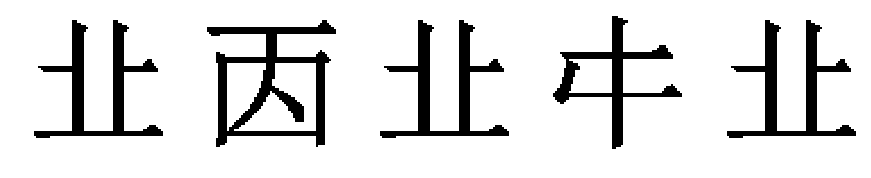

In [189]:
def show_images_random(images, number):
    fig = plt.figure(figsize=(15,20))
    random_indices = []
    for i in range(number):
        fig.add_subplot(1,number,i+1)
        plt.axis('off')
        random_index = random.randint(0, len(images))
        while random_index in random_indices :
            random_index = randint(0, len(images))
        plt.imshow(images[random_index], cmap='gray')
    
    plt.show()
    

def show_images(images, number):
    fig = plt.figure(figsize=(15,20))
    for i in range(number):
        fig.add_subplot(1,number,i+1)
        plt.axis('off')
        plt.imshow(images[i], cmap='gray')
    
    plt.show()
    
    
def show_images_T(images, number):
    fig = plt.figure(figsize=(15,20))
    for i in range(number):
        fig.add_subplot(1,number,i+1)
        plt.axis('off')
        plt.imshow(image_unloader(images[i,:,:,:]), cmap='gray')
    
    plt.show()    
       
    
def show_images_T_random(images, number):
    fig = plt.figure(figsize=(15,20))
    random_indices = []
    for i in range(number):
        fig.add_subplot(1,number,i+1)
        plt.axis('off')
        random_index = random.randint(0, len(images))
        while random_index in random_indices :
            random_index = randint(0, len(images))
        plt.imshow(image_unloader(images[i,:,:,:]), cmap='gray')
    
    plt.show()    

       
    
show_images([image_unloader(data[0][0]),image_unloader(data[1][0]),
             image_unloader(data[0][0]), image_unloader(data[4][0]),image_unloader(data[0][0])],5)
#show_images_T(data[1:6][0],5)

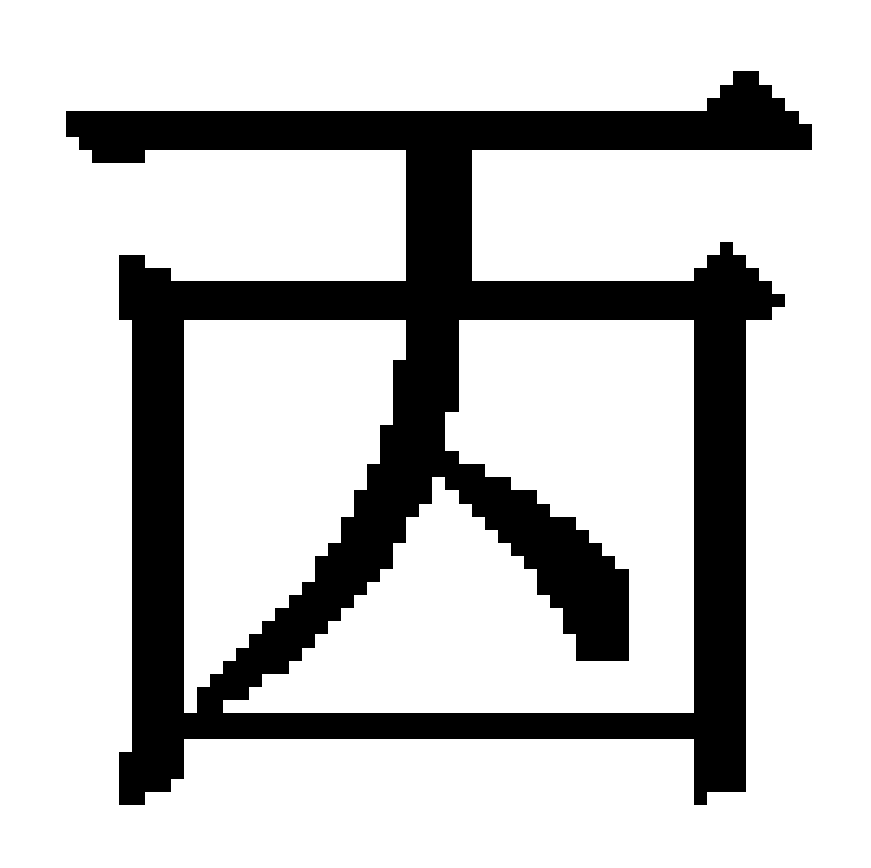

In [190]:
show_images_T(data[1][0].unsqueeze(0),1)

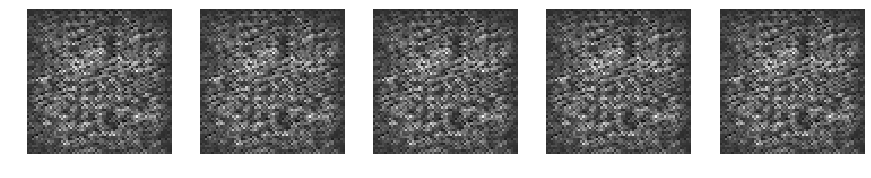

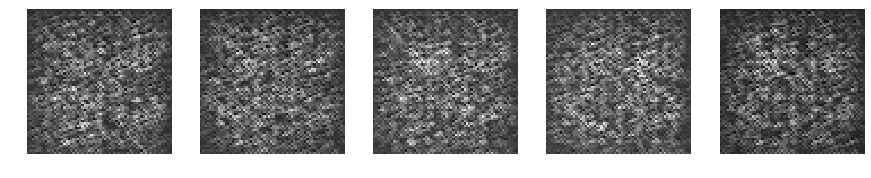

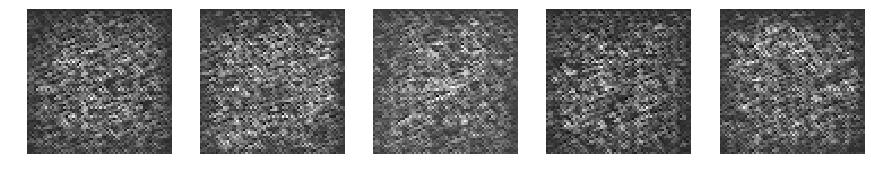

In [191]:
show_images_T(generator(torch.Tensor(np.ones((10,100)))),5)
show_images_T(generator(torch.Tensor(np.random.random(size=(10,100)))),5)
show_images_T(generator(torch.Tensor(np.random.normal(size=(10,100)))),5)

Start Training

-------------- iteration 0 --------------



mean loss 1: 0.000537 , mean loss 2: 0.073559
1 accuracy = 0.9998480704952902
0 accuracy = 0.8485262838043148


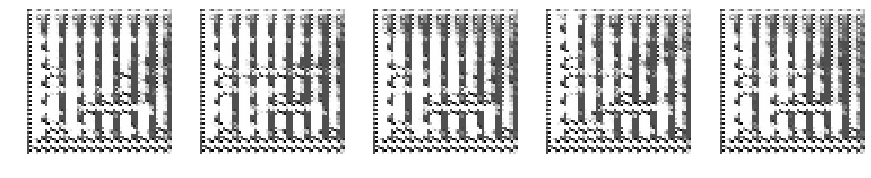


-------------- iteration 1 --------------



mean loss 1: 0.003733 , mean loss 2: 0.108980
1 accuracy = 0.854147675478578
0 accuracy = 0.8694925554542692


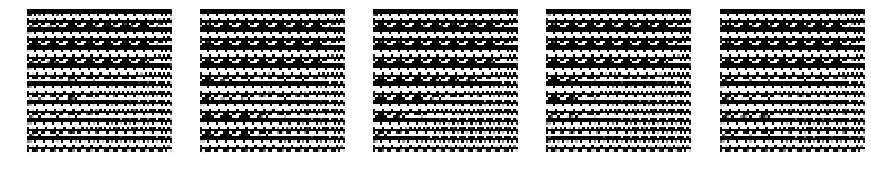


-------------- iteration 2 --------------



mean loss 1: 0.000157 , mean loss 2: 0.135900
1 accuracy = 0.998328775448192
0 accuracy = 1.0


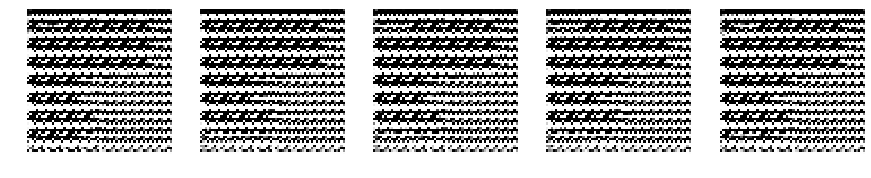


-------------- iteration 3 --------------



mean loss 1: 0.002604 , mean loss 2: 0.079158
1 accuracy = 0.9097538742023701
0 accuracy = 0.8865086599817684


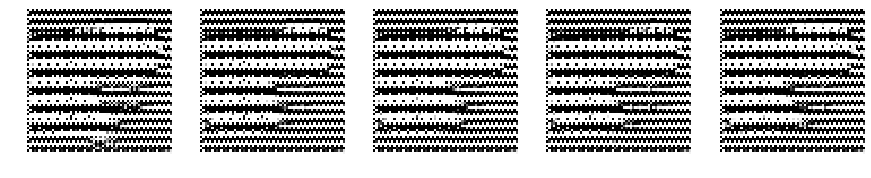


-------------- iteration 4 --------------



mean loss 1: 0.001415 , mean loss 2: 0.043072
1 accuracy = 0.9820723184442419
0 accuracy = 0.8163172288058341


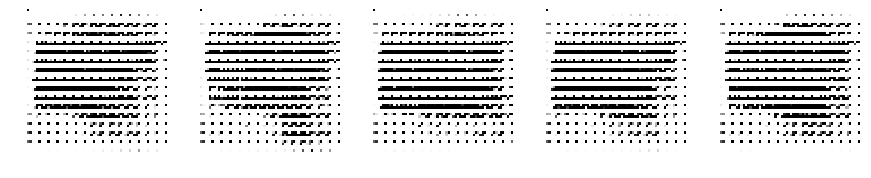


-------------- iteration 5 --------------



mean loss 1: 0.000674 , mean loss 2: 0.048643
1 accuracy = 0.9933151017927682
0 accuracy = 0.90990580370708


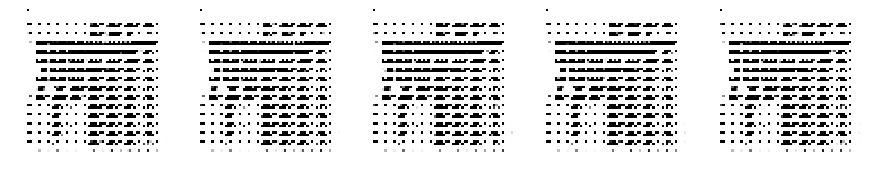


-------------- iteration 6 --------------



mean loss 1: 0.000196 , mean loss 2: 0.133467
1 accuracy = 0.995897903372835
0 accuracy = 0.9902765116985719


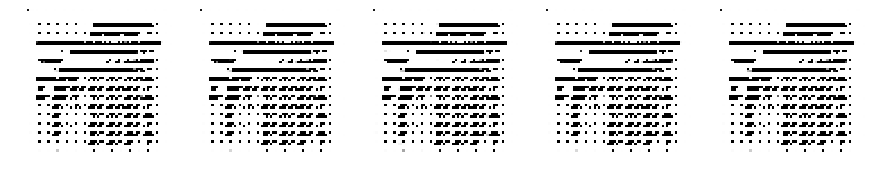


-------------- iteration 7 --------------



mean loss 1: 0.000184 , mean loss 2: 0.131530
1 accuracy = 0.9952901853539957
0 accuracy = 1.0


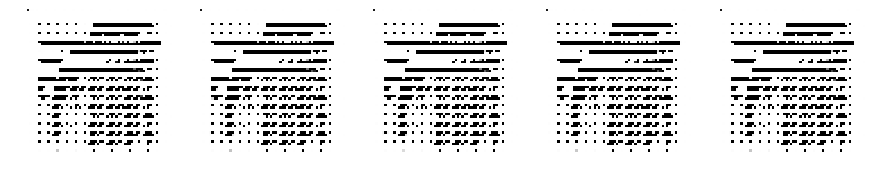


-------------- iteration 8 --------------



mean loss 1: 0.000188 , mean loss 2: 0.131174
1 accuracy = 0.9952901853539957
0 accuracy = 1.0


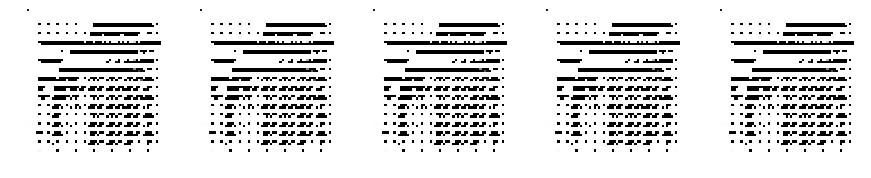


-------------- iteration 9 --------------



mean loss 1: 0.000188 , mean loss 2: 0.131017
1 accuracy = 0.9952901853539957
0 accuracy = 1.0


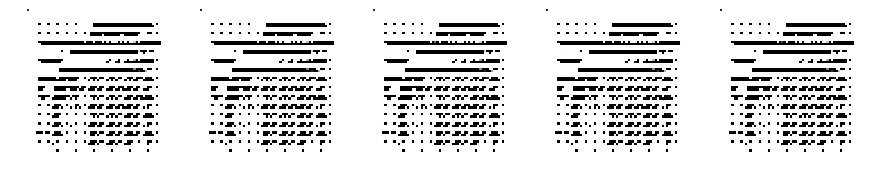


-------------- iteration 10 --------------



KeyboardInterrupt: 

In [192]:
#training the model

iterations = 10000

optimizer_dis = torch.optim.Adam(discriminator.model.parameters()
                                 , lr=0.001)
optimizer_gen = torch.optim.Adam(generator.model.parameters()
                                 , lr=0.005)
#criterion = torch.nn.MSELoss()
criterion = torch.nn.CrossEntropyLoss()
#softmax = torch.nn.sofm
#criterion = torch.nn.NLLLoss()

print('Start Training')
for i in range(iterations):
    print('')
    print('-------------- iteration {} --------------'.format(i))
    print('')
    generator.train()
    discriminator.train()
    
    sum_loss1 = 0
    sum_loss2 = 0
    number = 0
    predicted_number_1 = 0
    predicted_number_0 = 0
    losses_collection_1 = [0]*7
    losses_collection_2 = [0]*7
    for batch, (images, real_labels) in tqdm_notebook(enumerate(loader)):
        random_vector = torch.Tensor(np.random.normal(
            size = (images.shape[0], dimension)))
        fake_images = generator(random_vector)
                
        combined_images = torch.cat((images, fake_images), dim=0)
        fake_labels = torch.Tensor(np.zeros((fake_images.shape[0],1))).long()
        combined_labels = torch.cat((real_labels, fake_labels), dim=0).long()
        #combined_labels += torch.Tensor(
            #0.05*np.random.random(combined_labels.shape)).long()
        predicted_labels = discriminator(combined_images)
        
        loss1 = criterion(predicted_labels, combined_labels.squeeze(1))
        loss2 = criterion(predicted_labels[images.shape[0]:,:],
                          torch.Tensor(np.ones((fake_images.shape[0],1))).squeeze(1).long())
        
        sum_loss1 += loss1
        sum_loss2 += loss2
        number += images.shape[0]
        
        losses_collection_1.pop(0)
        losses_collection_1.append(loss1.item())
        
        losses_collection_2.pop(0)
        losses_collection_2.append(loss2.item())

        for i in range(images.shape[0]):
            if predicted_labels[i][0] < 0.5:
                predicted_number_1 += 1
            if predicted_labels[i+images.shape[0]][0] > 0.5:
                predicted_number_0 += 1
        
        if predicted_number_1/number > 0.8 and \
        predicted_number_0/number > 0.8 and \
        np.std(np.array(losses_collection_1)) + \
        np.std(np.array(losses_collection_2)) > 0.005 :

            #optimizer_dis.zero_grad()
            #loss1.backward(retain_graph=True)
            #optimizer_dis.step()

            optimizer_gen.zero_grad()
            loss2.backward()
            optimizer_gen.step()
        
        else :
            optimizer_dis.zero_grad()
            loss1.backward(retain_graph=True)
            optimizer_dis.step()

            optimizer_gen.zero_grad()
            loss2.backward()
            optimizer_gen.step()

    print('mean loss 1: {:4f} , mean loss 2: {:4f}'.format(sum_loss1.float()/(2*number),
                                                                               sum_loss2.float()/(number)))
    print('1 accuracy = {}'.format(predicted_number_1/number))
    print('0 accuracy = {}'.format(predicted_number_0/number))
    
    discriminator.eval()
    generator.eval()
    
    random_vector = torch.Tensor(np.random.normal(
            size = (5, dimension)))
    
    fake_images = generator(random_vector)
        
    show_images_T(fake_images, 5)
